Importing the libraries

In [7]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)
np.random.seed(42)

In [8]:
from nuclearpy_models.models.BE import dz_be, semf_be, dz_be, semf_be, sr_be, sr_fast_be, seeger_be
from nuclearpy_models.utils.metrics import RegressionMetrics

In case you want to perform rapid prototyping, you can use the following code to import the version without the uncertainty quantification.

In [9]:

seeger_be(20, 20), dz_be(20, 20), sr_be(20, 20)

(357.0708082207673, 342.5492, (341.11795959921363, 0.18745204759787265))

In [10]:
RUN_FAST_MODELS = False
if RUN_FAST_MODELS:
    print("Running fast models")
    sr_be = sr_fast_be

In [11]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"

## Dataset

In [12]:
exp_df = pd.read_csv('../../Data/Experimental/AME2020.csv', delimiter=',').query("Z>=12").query("Z<50")

# Binding energy prediction

In [13]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)
exp_df["seeger_pred"] = exp_df.apply(lambda x: seeger_be(x["Z"], x["N"]), axis=1)
for i in tqdm(range(1, 12)):
    exp_df[f"sr_pred_{i}"] = exp_df.apply(lambda x: sr_be(x["Z"], x["N"], i)[0], axis=1)
exp_df["sr_pred"] = exp_df.apply(lambda x: sr_be(x["Z"], x["N"])[0], axis=1)
exp_df["sr_error"] = exp_df["sr_pred"] - exp_df["BE"]
exp_df["dz_error"] = exp_df["dz_pred"] - exp_df["BE"]
exp_df["seeger_error"] = exp_df["seeger_pred"] - exp_df["BE"]


  0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='N', ylabel='seeger_error'>

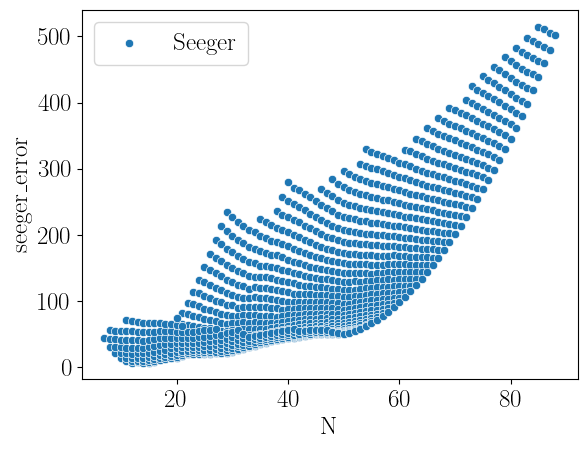

In [14]:
sns.scatterplot(x=exp_df["N"], y=exp_df["seeger_error"], label="Seeger")

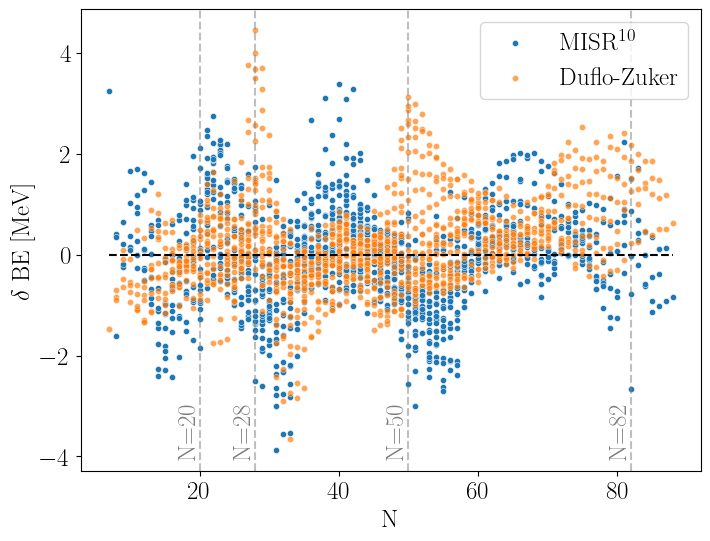

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(data=exp_df, x="N", y="sr_error", label=r"MISR$^{10}$", s=20)
sns.scatterplot(data=exp_df, x="N", y="dz_error", label="Duflo-Zuker", alpha=0.7, s=20)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set(xlabel="N", ylabel=r"$\delta$ BE [MeV]")
magic_numbers = [20, 28, 50, 82]
for i in magic_numbers:
    ax.axvline(i, color="grey", linestyle="--", alpha=0.5)
    ax.text(i, -3.5, f"N={i}", rotation=90, verticalalignment="center", horizontalalignment="right", color="grey")
plt.hlines(0, exp_df.N.min(), exp_df.N.max(), color="black", linestyle="--")
plt.savefig("./plots/sr_dz_error.pdf", bbox_inches="tight")

#### Loading theory model's predictions

In [16]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames
used_dfs = [
    # "DD-ME2",
    # "SKMS",
    # "NL3S",
    "UNEDF1",
]
th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste).query("Z >= 12").query("Z<50") for th_dataste in th_datastes}

In [17]:
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_dz(Z, N):
    try:
        return dz_be(Z, N)
    except Exception as e:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_dz(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_dz(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    all_th_in_exp[df_name] = foo.dropna()


In [18]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
seeger_metrics = RegressionMetrics(exp_df["BE"], exp_df["seeger_pred"], "Seeger")()
all_sr_metrics = []
for i in range(1, 12):
    sr_metrics = RegressionMetrics(exp_df["BE"], exp_df[f"sr_pred_{i}"], f"SR{i}")()
    all_sr_metrics.append(sr_metrics)

results = pd.concat([semf_metrics, dz_metrics, seeger_metrics] + all_sr_metrics, axis=0)

for df_name in used_dfs:
   res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
   results = pd.concat([results, res], axis=0)
all_th_dfs: Dict[str, pd.DataFrame]

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})
dz_rmse = results.reset_index().query("index == 'DZ'")["RMSE"].values[0]

In [19]:
results[["MAE", "RMSE"]]

,MAE,RMSE
SEMF,3.547973,5.091692
DZ,0.640284,0.892970
Seeger,134.770945,176.705583
SR1,5.109575,6.172339
SR2,1.466801,1.833161
SR3,1.215596,1.552983
SR4,1.095054,1.369571
SR5,1.053389,1.307613
SR6,1.002138,1.251572
SR7,0.904368,1.167769


In [20]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [dz_be, dz_be],
    model_names: List[str] = ["DZ", "SR"],
    fixed_z: int = 50,
    n_max = 120,
    ):

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = df.query(f"Z=={fixed_z}")
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="Duflo Zuker", color="black", alpha=0.5)
    plt.errorbar(foo_df["N"], foo_df["BE"], yerr=foo_df["uBE"], fmt="o", label="Experiment", color="black")
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    SEMF_error = foo_df["dz_pred"] - foo_df["BE"]
    sns.scatterplot(x="N", y=SEMF_error, data=foo_df, ax=ax, label=None, color="black")
    for i, (model, name) in enumerate(zip(models, model_names)):
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        if isinstance(preds_in[0], (list, np.ndarray)):
            preds_in = [x[0] for x in preds_in]
        print(preds_in)
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")

    ax.set(xlabel="N", ylabel=r"$\delta(BE)$ [MeV]", xlim=(n_min, n_max), ylim=(-10, 10))
    ax.legend(fontsize=14)
    ax.annotate(f"Z={fixed_z}", xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    ax.legend(fontsize=14)
    plt.savefig(f"BE_{fixed_z}.pdf", bbox_inches="tight")

# Unseen data

In [21]:
be_test = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_test.csv", delimiter=",").query("Z>=12").query("Z<50")
be_test["is_test"] = [True] * len(be_test)
be_train = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_train.csv", delimiter=",").query("Z>=12").query("Z<50")
be_train["is_test"] = [False] * len(be_train)
full_exp_df = pd.concat([be_test, be_train], axis=0)

In [22]:
%%capture
for i in range(1, 11):
    full_exp_df[f"sr_pred_{i}"] = full_exp_df.apply(lambda x: sr_be(x["Z"], x["N"], i)[0], axis=1)
full_exp_df["SEMF"] = full_exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
full_exp_df["dz_pred"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

In [23]:
full_exp_df = full_exp_df.query("Z > 12 and Z <= 50")
for df_name in used_dfs:
    foo = full_exp_df.copy()
    full_exp_df[f"th_pred_{df_name}"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)


In [24]:
def simple_sn(Z, N, model):
    return model(Z, N + 1) - model(Z, N)
def simple_sp(Z, N, model):
    return model(Z+1, N) - model(Z, N)
def exp_sn(Z, N):
    try:
        return exp_df[(exp_df["Z"] == Z) & (exp_df["N"] == N + 1)]["BE"].values[0] - exp_df[(exp_df["Z"] == Z) & (exp_df["N"] == N)]["BE"].values[0]
    except:
        return np.nan
def exp_sp(Z, N):
    try:
        return exp_df[(exp_df["Z"] == Z + 1) & (exp_df["N"] == N)]["BE"].values[0] - exp_df[(exp_df["Z"] == Z) & (exp_df["N"] == N)]["BE"].values[0]
    except:
        return np.nan

In [25]:
for i in range(1, 11):
    full_exp_df[f"sr_sn_{i}"] = full_exp_df.apply(lambda x: simple_sn(x["Z"], x["N"], lambda Z, N: sr_be(Z, N, i)[0]), axis=1)
    full_exp_df[f"sr_sp_{i}"] = full_exp_df.apply(lambda x: simple_sp(x["Z"], x["N"], lambda Z, N: sr_be(Z, N, i)[0]), axis=1)
full_exp_df[f"semf_sn"] = full_exp_df.apply(lambda x: simple_sn(x["Z"], x["N"], semf_be), axis=1)
full_exp_df[f"semf_sp"] = full_exp_df.apply(lambda x: simple_sp(x["Z"], x["N"], semf_be), axis=1)
full_exp_df[f"dz_sn"] = full_exp_df.apply(lambda x: simple_sn(x["Z"], x["N"], dz_be), axis=1)
full_exp_df[f"dz_sp"] = full_exp_df.apply(lambda x: simple_sp(x["Z"], x["N"], dz_be), axis=1)
full_exp_df[f"exp_sn"] = full_exp_df.apply(lambda x: exp_sn(x["Z"], x["N"]), axis=1)
full_exp_df[f"exp_sp"] = full_exp_df.apply(lambda x: exp_sp(x["Z"], x["N"]), axis=1)

In [26]:
be_errors_sr_train = []
be_errors_sr_train_std = []
be_errors_sr_test = []
be_errors_sr_test_std = []
sn_errors_sr_train = []
sn_errors_sr_train_std = []
sn_errors_sr_test = []
sn_errors_sr_test_std = []
sp_errors_sr_train = []
sp_errors_sr_train_std = []
sp_errors_sr_test = []
sp_errors_sr_test_std = []


for i in range(1, 11):
    mae_train = np.abs(full_exp_df.query("is_test == False")[f"sr_pred_{i}"] - full_exp_df.query("is_test == False")["BE"]).mean()
    mae_test = np.abs(full_exp_df.query("is_test == True")[f"sr_pred_{i}"] - full_exp_df.query("is_test == True")["BE"]).mean()
    mae_train_std = np.abs(full_exp_df.query("is_test == False")[f"sr_pred_{i}"] - full_exp_df.query("is_test == False")["BE"]).std()
    mae_test_std = np.abs(full_exp_df.query("is_test == True")[f"sr_pred_{i}"] - full_exp_df.query("is_test == True")["BE"]).std()
    be_errors_sr_train.append(mae_train)
    be_errors_sr_test.append(mae_test)
    be_errors_sr_train_std.append(mae_train_std)
    be_errors_sr_test_std.append(mae_test_std)

    # For sp and sn
    mae_train = np.abs(full_exp_df.query("is_test == False")[f"sr_sn_{i}"] - full_exp_df.query("is_test == False")["exp_sn"]).mean()
    mae_test = np.abs(full_exp_df.query("is_test == True")[f"sr_sn_{i}"] - full_exp_df.query("is_test == True")["exp_sn"]).mean()
    mae_train_std = np.abs(full_exp_df.query("is_test == False")[f"sr_sn_{i}"] - full_exp_df.query("is_test == False")["exp_sn"]).std()
    mae_test_std = np.abs(full_exp_df.query("is_test == True")[f"sr_sn_{i}"] - full_exp_df.query("is_test == True")["exp_sn"]).std()
    sn_errors_sr_train.append(mae_train)
    sn_errors_sr_test.append(mae_test)
    sn_errors_sr_train_std.append(mae_train_std)
    sn_errors_sr_test_std.append(mae_test_std)
    mae_train = np.abs(full_exp_df.query("is_test == False")[f"sr_sp_{i}"] - full_exp_df.query("is_test == False")["exp_sp"]).mean()
    mae_test = np.abs(full_exp_df.query("is_test == True")[f"sr_sp_{i}"] - full_exp_df.query("is_test == True")["exp_sp"]).mean()
    mae_train_std = np.abs(full_exp_df.query("is_test == False")[f"sr_sp_{i}"] - full_exp_df.query("is_test == False")["exp_sp"]).std()
    mae_test_std = np.abs(full_exp_df.query("is_test == True")[f"sr_sp_{i}"] - full_exp_df.query("is_test == True")["exp_sp"]).std()
    sp_errors_sr_train.append(mae_train)
    sp_errors_sr_test.append(mae_test)
    sp_errors_sr_train_std.append(mae_train_std)
    sp_errors_sr_test_std.append(mae_test_std)



In [27]:
semf_train = np.abs(full_exp_df.query("is_test == False")["SEMF"] - full_exp_df.query("is_test == False")["BE"]).mean()
semf_test = np.abs(full_exp_df.query("is_test == True")["SEMF"] - full_exp_df.query("is_test == True")["BE"]).mean()

sn_semf_train = np.abs(full_exp_df.query("is_test == False")["semf_sn"] - full_exp_df.query("is_test == False")["exp_sn"]).mean()
sn_semf_test = np.abs(full_exp_df.query("is_test == True")["semf_sn"] - full_exp_df.query("is_test == True")["exp_sn"]).mean()

sp_semf_train = np.abs(full_exp_df.query("is_test == False")["semf_sp"] - full_exp_df.query("is_test == False")["exp_sp"]).mean()
sp_semf_test = np.abs(full_exp_df.query("is_test == True")["semf_sp"] - full_exp_df.query("is_test == True")["exp_sp"]).mean()

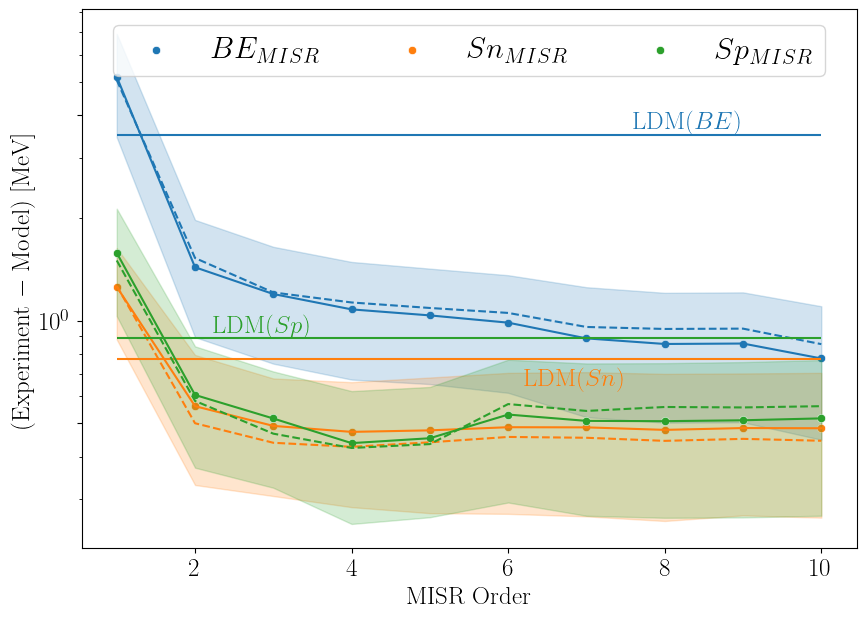

In [28]:
# Now the same as before, but in a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
# The errors in the BE
colors = sns.color_palette("tab10")
sns.lineplot(x=np.arange(1, 11), y=be_errors_sr_train, label=None, ax=ax, color=colors[0])
sns.lineplot(x=np.arange(1, 11), y=be_errors_sr_test, label=None, ax=ax, ls="--", color=colors[0])
sns.scatterplot(x=np.arange(1, 11), y=be_errors_sr_train, ax=ax, label=r"$BE_{MISR}$", color=colors[0])
ax.fill_between(np.arange(1, 11), np.array(be_errors_sr_train) - np.array(be_errors_sr_train_std)/2, np.array(be_errors_sr_train) + np.array(be_errors_sr_train_std)/2, alpha=0.2, color=colors[0])
ax.hlines(semf_train, 1, 10, color=colors[0], label=None)
ax.text(9, semf_train, r"LDM($BE$)", verticalalignment="bottom", horizontalalignment="right", color=colors[0])

# The errors in the Sn
sns.lineplot(x=np.arange(1, 11), y=sn_errors_sr_train, label=None, ax=ax, color=colors[1])
sns.lineplot(x=np.arange(1, 11), y=sn_errors_sr_test, label=None, ax=ax, ls="--", color=colors[1])
sns.scatterplot(x=np.arange(1, 11), y=sn_errors_sr_train, ax=ax, label=r"$Sn_{MISR}$", color=colors[1])
ax.fill_between(np.arange(1, 11), np.array(sn_errors_sr_train) - np.array(sn_errors_sr_train_std)/2, np.array(sn_errors_sr_train) + np.array(sn_errors_sr_train_std)/2, alpha=0.2, color=colors[1])
ax.hlines(sn_semf_train, 1, 10, color=colors[1], label=None)
ax.text(7.5, sn_semf_train - 0.15, "LDM($Sn$)", verticalalignment="bottom", horizontalalignment="right", color=colors[1])

# The errors in the Sp
sns.lineplot(x=np.arange(1, 11), y=sp_errors_sr_train, label=None, ax=ax, color=colors[2])
sns.lineplot(x=np.arange(1, 11), y=sp_errors_sr_test, label=None, ax=ax, ls="--", color=colors[2])
sns.scatterplot(x=np.arange(1, 11), y=sp_errors_sr_train, ax=ax, label=r"$Sp_{MISR}$", color=colors[2])
ax.fill_between(np.arange(1, 11), np.array(sp_errors_sr_train) - np.array(sp_errors_sr_train_std)/2, np.array(sp_errors_sr_train) + np.array(sp_errors_sr_train_std)/2, alpha=0.2, color=colors[2])
ax.hlines(sp_semf_train, 1, 10, color=colors[2], label=None)
ax.text(3.5, sp_semf_train, "LDM($Sp$)", verticalalignment="bottom", horizontalalignment="right", color=colors[2])

ax.set(yscale="log", xlabel="MISR Order", ylabel=r"(Experiment $-$ Model) [MeV]")
ax.legend(
    loc="upper center", ncols=3, fontsize=22
)
ax.set(yticks=[0.5, 1, 4])
plt.savefig("./plots/BE_SR_errors.pdf", bbox_inches="tight")

/Users/jose/anaconda3/envs/envSr/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


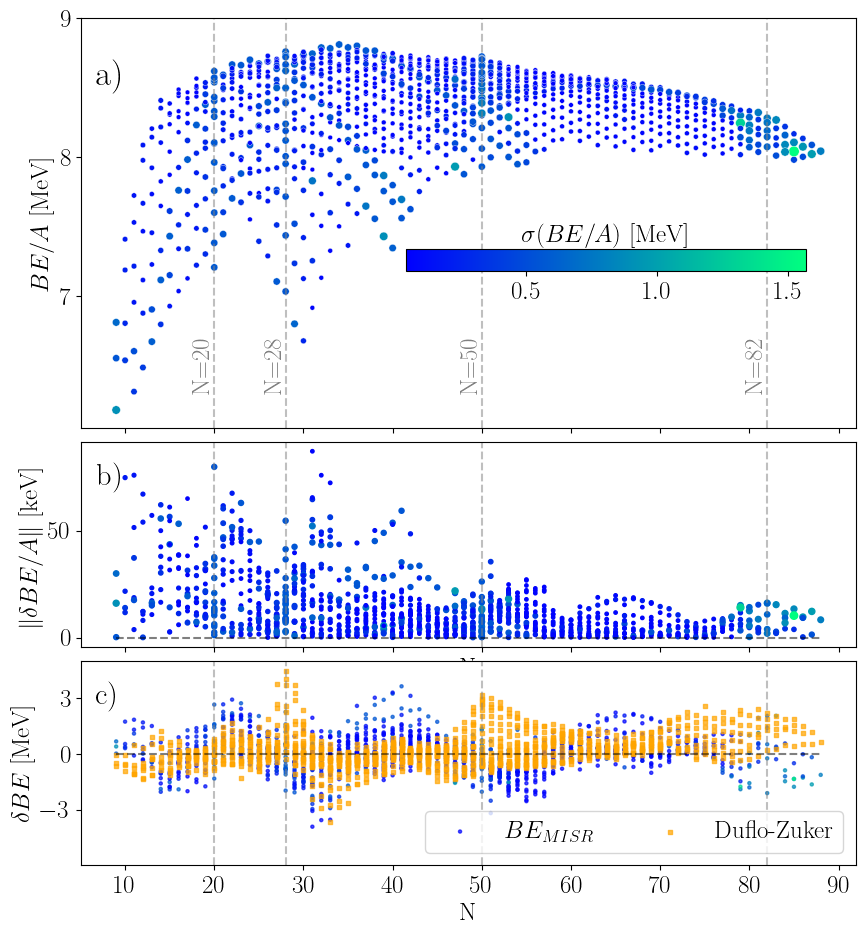

In [29]:
from matplotlib.colors import Normalize
COLORMAP = "winter"
fig, ax = plt.subplots(3, 1 , figsize=(10, 11), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
fo_df = full_exp_df.copy()
fo_df["error_misr_10"] = np.abs(fo_df["sr_pred_10"] - fo_df["BE"])
fo_df["uncertainty_misr_10"] = fo_df.apply(lambda x: sr_be(x["Z"], x["N"], 10)[1], axis=1)
norm = Normalize(vmin=fo_df["uncertainty_misr_10"].min(), vmax=fo_df["uncertainty_misr_10"].max())
sns.scatterplot(x=fo_df["N"], y=fo_df["sr_pred_10"]/fo_df["A"], ax=ax[0], hue=fo_df["uncertainty_misr_10"], palette=COLORMAP, legend=False, norm=norm, s=fo_df["uncertainty_misr_10"]*30+10)
sm = plt.cm.ScalarMappable(cmap=COLORMAP, norm=norm)
cbar_ax = fig.add_axes([0.45, 0.65, 0.4, 0.02])  # Position of the colorbar [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.ax.set_title(r"$\sigma(BE/A)$ [MeV]", fontsize=18, rotation=0)
# Add text saying the 'a)'
ax[0].text(0.02, 0.9, "a)", transform=ax[0].transAxes, fontsize=25, verticalalignment="top")
magic_numbers = [20, 28, 50, 82]
for i in magic_numbers:
    ax[0].axvline(i, color="grey", linestyle="--", alpha=0.5)
    ax[0].text(i, 6.5, f"N={i}", rotation=90, verticalalignment="center", horizontalalignment="right", color="grey")
ax[0].set(xlabel="N", ylabel=r"$BE/A$ [MeV]", yticks=[7., 8.0, 9.])

# Plot 2
for i in magic_numbers:
    ax[1].axvline(i, color="grey", linestyle="--", alpha=0.5)
    ax[2].axvline(i, color="grey", linestyle="--", alpha=0.5)
res_sr = (fo_df["sr_pred_10"] - fo_df["BE"])
ax[1].text(0.02, 0.9, "b)", transform=ax[1].transAxes, fontsize=22, verticalalignment="top")

ax[1].scatter(fo_df["N"], res_sr.abs()*1000/fo_df["A"], c=fo_df["uncertainty_misr_10"], norm=norm, cmap=COLORMAP, s=fo_df["uncertainty_misr_10"]*15+5)
ax[1].set(xlabel="N", ylabel=r"$\|\delta BE/A\|$ [keV]", yticks=[0, 50])
ax[1].hlines(0, fo_df["N"].min(), fo_df["N"].max(), color="black", linestyle="--", alpha=0.5)

# Plot 3
res_dz = (fo_df["dz_pred"] - fo_df["BE"])
ax[2].scatter(fo_df["N"], res_sr, s=5, label="$BE_{MISR}$", alpha=0.7, c=fo_df["uncertainty_misr_10"], norm=norm, cmap=COLORMAP)
ax[2].scatter(fo_df["N"], res_dz, s=5, label="Duflo-Zuker", alpha=0.7, marker="s", c = "orange")
ax[2].set(xlabel="N", ylabel=r"$\delta BE$ [MeV]", yticks=[-3, 0, 3], ylim= (-6, 5))
ax[2].legend(ncols=2)
ax[2].hlines(0, fo_df["N"].min(), fo_df["N"].max(), color="black", linestyle="--", alpha=0.5)
ax[2].text(0.02, 0.9, "c)", transform=ax[2].transAxes, fontsize=22, verticalalignment="top")

plt.subplots_adjust(hspace=0.05)
plt.savefig("./plots/BE_A.pdf", bbox_inches="tight")


# Smart ensemble of the models

In [30]:
from sklearn.linear_model import ARDRegression, BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "polynomialfeatures__degree": [1, 2, 3, 4, 5],
    "ardregression__alpha_1": [1e-6, 1e-5, 1e-4],
    "ardregression__alpha_2": [1e-6, 1e-5, 1e-4],
    "ardregression__lambda_1": [1e-6, 1e-5, 1e-4],
    "ardregression__lambda_2": [1e-6, 1e-5, 1e-4],
}

model_pred_be = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    ARDRegression(
    )
)
search = GridSearchCV(model_pred_be, param_grid, n_jobs=-1, cv=5)
search.fit(full_exp_df.query("is_test == False")[["sr_pred_10", "dz_pred", "N", "Z"]].values,
          full_exp_df.query("is_test == False")["BE"])
search.best_params_


{'ardregression__alpha_1': 0.0001,
 'ardregression__alpha_2': 1e-06,
 'ardregression__lambda_1': 1e-06,
 'ardregression__lambda_2': 1e-06,
 'polynomialfeatures__degree': 5}

In [32]:

model_pred_be = make_pipeline(
    PolynomialFeatures(degree=5, include_bias=False, interaction_only=False),
    StandardScaler(),
    ARDRegression(
        alpha_1=0.0001,
        alpha_2=1e-06,
        lambda_1=1e-06,
        lambda_2=1e-06,
    )
)

model_pred_be.fit(full_exp_df.query("is_test == False")[["sr_pred_10", "dz_pred", "N", "Z"]].values,
          full_exp_df.query("is_test == False")["BE"])

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('ardregression', ARDRegression(alpha_1=0.0001))])

In [33]:
def resample_data_from_uncertainties(df: pd.DataFrame, seed=42) -> pd.DataFrame:
    new_target_df = df.copy().sample(frac=0.8, replace=True, random_state=seed)
    return new_target_df

def train_models_on_resampled_data(df: pd.DataFrame, n_samples: int = 1_00) -> List[ARDRegression]:
    ndf = df.copy()
    models = []
    for i in tqdm(range(n_samples)):
        sampled_df = resample_data_from_uncertainties(ndf, seed=i)
        model = make_pipeline(
            PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
            StandardScaler(),
            ARDRegression(),
        )
        model.fit(sampled_df[["sr_pred_10", "dz_pred", "N", "Z"]].values, sampled_df["BE"].values)
        models.append(model)
    return models

def get_comitee_predictions(models: List[ARDRegression], X: np.ndarray) -> np.ndarray:
    preds = np.array([model.predict(X, return_std=True) for model in models])
    m_pred = preds[:, 0, :]
    m_std = preds[:, 1, :]
    all_model_preds = np.mean(m_pred, axis=0)
    all_model_std = np.std(m_pred, axis=0)
    all_model_unce = np.mean(m_std, axis=0)
    return all_model_preds[0], (all_model_std**2 + all_model_unce**2)**0.5

In [34]:
def model_ensemble_predict(Z, N, models):
    return get_comitee_predictions(models, [[sr_be(Z, N, 10)[0], dz_be(Z, N), N, Z]])

def simple_model_ensemble(Z, N):
    preds = model_pred_be.predict([[sr_be(Z, N)[0], dz_be(Z, N), N, Z]], return_std=True)
    return preds[0][0],( preds[1][0]**2+sr_be(Z, N)[1]**2)**0.5

convert_to_boostrapped = False
if convert_to_boostrapped:
    models = train_models_on_resampled_data(full_exp_df.query("is_test == False"), n_samples=20)
    lambda x: model_ensemble_predict(x["Z"], x["N"], models)

In [35]:
ens =  full_exp_df.apply(lambda x: simple_model_ensemble(x["Z"], x["N"]), axis=1)
ensemble_pred = [x[0] for x in ens]
ensemble_unc = [x[1] for x in ens]
full_exp_df["ensemble_pred"] = ensemble_pred
full_exp_df["ensemble_error"] = full_exp_df["ensemble_pred"] - full_exp_df["BE"]

In [36]:
print("TEST:")
rmse, mae = np.sqrt(np.mean(full_exp_df.query("is_test==1")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==1")["ensemble_error"]))
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")
print("TRAIN:")
trmse, tmae = np.sqrt(np.mean(full_exp_df.query("is_test==0")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==0")["ensemble_error"]))
print(f"RMSE: {trmse:.3f}, MAE: {tmae:.3f}")

TEST:
RMSE: 0.556, MAE: 0.411
TRAIN:
RMSE: 0.535, MAE: 0.389


<Axes: xlabel='N', ylabel='ensemble_error'>

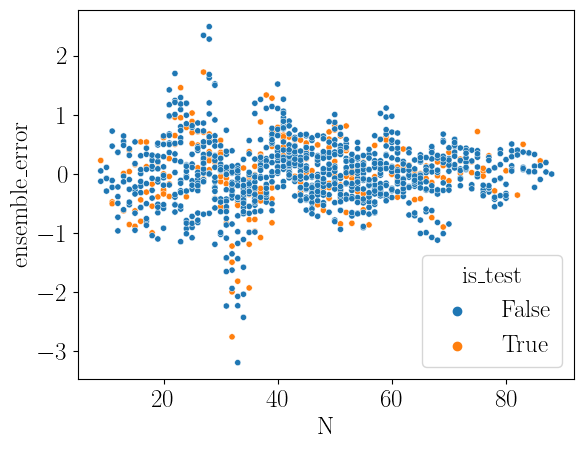

In [37]:
sns.scatterplot(x="N", y="ensemble_error", data=full_exp_df, s=20, hue="is_test")

# Neutron Separation energies

In [38]:
sep_df = full_exp_df.copy()


In [39]:
def predict_sn(Z, N, model):
    model_up = model(Z, N+1)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

# def experimental_sn(df):
#     for i, row in df.iterrows():
#         try:
#             df.at[i, "sn_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+1)]["tBE"].values[0] - row["BE"]
#         except:
#             df.at[i, "sn_exp"] = np.nan
#     return df

def uncertainty_sn(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sn_exp"] = (df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+1)]["uBE"].values[0]**2 + row["uBE"]**2)**0.5
        except:
            df.at[i, "sn_exp"] = 1e-9
    return df


def theory_sn(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+1)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan



In [40]:
# sep_df["exp_sn"] = experimental_sn(sep_df)["sn_exp"]
# sep_df["unc_sn"] = uncertainty_sn(sep_df)["sn_exp"]
sep_df["sr_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], lambda Z, N: sr_be(Z, N, -1)[0]), axis=1)
sep_df["dz_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], dz_be), axis=1)

# # Other approach... simply fit a model the same way we did for the BE

# model_pred_sn = make_pipeline(
#     PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
#     StandardScaler(),
#     ARDRegression(),
# )
# model_pred_sn.fit(sep_df.dropna().query("is_test == False")[["sr_sn", "dz_sn", "N", "Z"]].values,
#             sep_df.dropna().query("is_test == False")["exp_sn"])


# def train_sn_models_on_resampled_data(df: pd.DataFrame, n_samples: int = 1_00) -> List[ARDRegression]:
#     """
#     Train the models on the resampled data
#     """
#     ndf = df.copy()
#     models = []
#     for i in tqdm(range(n_samples)):
#         sampled_df = resample_data_from_uncertainties(ndf, seed=i)
#         model = make_pipeline(
#             PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
#             StandardScaler(),
#             ARDRegression(),
#         )
#         model.fit(sampled_df.dropna()[["sr_sn", "dz_sn", "N", "Z"]].values, sampled_df.dropna()["exp_sn"].values)
#         models.append(model)
#     return models

# models_sn = train_sn_models_on_resampled_data(sep_df.query("is_test == False"), n_samples=20)

# def ensemble_sn(Z, N, model=model_pred_sn):
#     inpupt_sr = sr_be(Z, N + 1)[0] - sr_be(Z, N)[0]
#     input_dz = dz_be(Z, N + 1) - dz_be(Z, N)
#     all_preds = np.array([model.predict([[inpupt_sr, input_dz, N, Z]], return_std=True) for model in models_sn])
#     m_pred = all_preds[:, 0, :]
#     m_std = all_preds[:, 1, :]
#     all_model_preds = np.mean(m_pred, axis=0)
#     all_model_std = np.std(m_pred, axis=0)
#     all_model_unce = np.mean(m_std, axis=0)
#     return all_model_preds[0], (all_model_std[0]**2 + all_model_unce[0]**2)**0.5

# def ensemble_sn(Z, N, model=model_pred_sn):
#     inpupt_sr = sr_be(Z, N + 1)[0] - sr_be(Z, N)[0]
#     uncertainty_sr = (sr_be(Z, N + 1)[1]**2 + sr_be(Z, N)[1]**2)**0.5
#     input_dz = dz_be(Z, N + 1) - dz_be(Z, N)
#     preds = model.predict([[inpupt_sr, input_dz, N, Z]], return_std=True)
#     return preds[0][0], (preds[1][0] ** 2 + uncertainty_sr**2)**0.5

def ensemble_sn(Z, N):
    up, up_unc = simple_model_ensemble(Z, N + 1)
    down, down_unc = simple_model_ensemble(Z, N)
    return up - down, (up_unc**2 + down_unc**2)**0.5


ens_sn = sep_df.apply(lambda x: ensemble_sn(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sn"] = [x[0] for x in ens_sn]
sep_df["unc_sn"] = [x[1] for x in ens_sn]

In [41]:
ensemble_sn(Z=50, N=50)

(10.358715895294722, 1.205089264707654)

<Axes: xlabel='Z'>

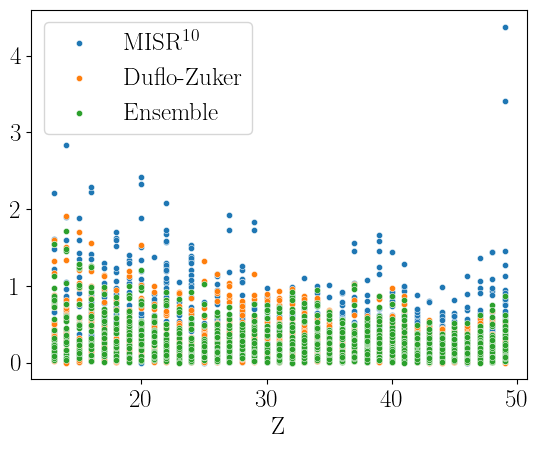

In [42]:
sr_sn_residual = (sep_df["exp_sn"] - sep_df["sr_sn"]).abs()
ensemble_residual = (sep_df["exp_sn"] - sep_df["ensemble_sn"]).abs()
dz_sn_residual = (sep_df["exp_sn"] - sep_df["dz_sn"]).abs()
sns.scatterplot(x="Z", y=sr_sn_residual, data=sep_df, s=20, label="MISR$^{10}$")
sns.scatterplot(x="Z", y=dz_sn_residual, data=sep_df, s=20, label="Duflo-Zuker")
sns.scatterplot(x="Z", y=ensemble_residual, data=sep_df, s=20, label="Ensemble")

In [43]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sn"] = sep_df.apply(lambda x: theory_sn(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [44]:
def get_experimiental_unc_sn(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+1)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [45]:
dz_rmse = np.mean(np.abs((sep_df["exp_sn"] - sep_df["dz_sn"])))
sr_rmse = np.mean(np.abs((sep_df["exp_sn"] - sep_df["sr_sn"])))
ensm_rmse = np.mean(np.abs((sep_df["exp_sn"] - sep_df["ensemble_sn"])))
print(f"SR MAE: {sr_rmse}, DZ MAE: {dz_rmse}, Ensemble MAE: {ensm_rmse}")

SR MAE: 0.4580617713684263, DZ MAE: 0.29941813883740925, Ensemble MAE: 0.28293180497582665


In [46]:
def plot_sn_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models

    pres = [ensemble_sn(fixed_z, n) for n in range(n_min, n_max+1)]
    unc_pred = [x[1] for x in pres]
    pres = [x[0] for x in pres]

    print(pres, unc_pred)
    predz = [predict_sn(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    predsr = [predict_sn(fixed_z, n, sr_be) for n in range(n_min, n_max+1)]
    uncsr = [x[1] for x in predsr]
    predsr = [x[0] for x in predsr]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sn"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    # plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sn"]))

    sns.lineplot(x="N", y="exp_sn", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="ARD", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="_")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="red", marker="*", s=200)
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=predsr, label=r"$Sn_{MISR}$", color="orange", marker="_", s=200)

    sns.scatterplot(x="N", y="UNEDF1_sn", data=foo_df, label="UNEDF1", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_n$ [MeV]")
    ax.set_xlim(n_min, n_max+1)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=18, loc="lower left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


[4.201852842672793, 5.404616987259715, 3.1926297988309216, 4.340200582299019, 2.3988284710955554, 3.4259560593466745, 1.7466949914277166, 2.6642081094016703, 1.2225131506168054, 2.0379403863390735, 0.7930284524518356, 1.6099229235899202, 0.29589559028869417, 0.8818725205396163, -0.0014727448305507096, 0.6518420956232376, -0.12452900650191623, 0.4841621189423222] [0.7865999692228435, 0.7843325667059349, 0.7862272808796165, 0.7909530930415795, 0.7997106607776807, 0.8130126117305785, 0.8273719525644351, 0.8462019091019091, 0.8734973414102379, 0.9002016054421912, 0.9264600054793184, 0.947996988989932, 0.9519693038245614, 0.9500534286216265, 0.9536512425179909, 0.9459568005026686, 0.9467750305774496, 0.9476788065367399]
18 29


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_71907/1682191394.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="ARD", color="blue", capsize=5, alpha=0.5)


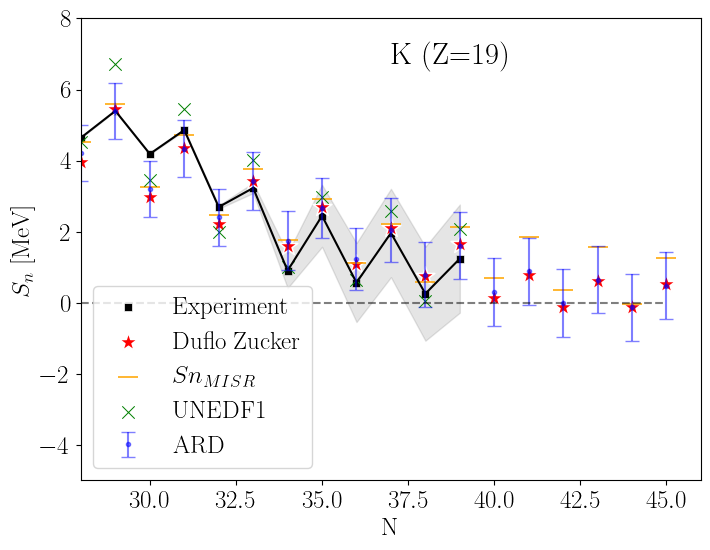

In [47]:
plot_sn_energy(19, 28, 45, "K (Z=19)", "./plots/sn_19.pdf")

In [48]:
def plot_several_separation_energies(Zs, n_min, n_max, names=[]):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    colors = sns.color_palette("tab10", len(Zs))
    for idx, z in enumerate(Zs):
        foo_df = sep_df.query(f"Z=={z}").query(f"N>={n_min} and N<={n_max}")
        # predict for models
        # pres = [ predict_sn(z, n, lambda Z, N: sr_be(Z, N, -1)) for n in range(n_min, n_max+1)]
        pres = [ensemble_sn(z, n) for n in range(n_min, n_max+1)]
        unc_pred = [x[1] for x in pres]
        pres = [x[0] for x in pres]
        exp = []
        unc = []
        ns = []
        for n in range(n_min, n_max+1):
            try:
                exp.append(sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_sn"].values[0])
                unc.append(get_experimiental_unc_sn(z, n, sep_df))
                ns.append(n)
            except:
                exp.append(np.nan)
                unc.append(np.nan)
        # sns.scatterplot(x="N", y="exp_sn", data=foo_df, color=colors[idx], label=f"Z={z}", marker="s")
        plt.errorbar(range(n_min, n_max), exp[:-1], yerr=unc[:-1], label= None, color=colors[idx], capsize=5,  fmt='s')
        # Foo for legend
        if idx==0:
            plt.errorbar([0], [0], yerr=[1], label= f"Experiment", color="black", capsize=5,  fmt='s')
        # plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="MISR", capsize=5, alpha=0.5, color=colors[idx])
        for i in range(len(pres)-1):
            plt.hlines(pres[i], n_min+i-0.5, n_min+i+1-0.5, color=colors[idx], label=f"ARD. {names[idx]} (Z={z})" if i == 0 else "")
        # if not names:
        #     plt.stairs(pres[:-1], np.arange(n_min, n_max+1)-0.5, color=colors[idx], label=f"ARD. Z={z}")
        # else:
        #     plt.stairs(pres[:-1], np.arange(n_min, n_max+1)-0.5, color=colors[idx], label=f"ARD. " + names[idx] + f" (Z={z})")
        for i, (p, u) in enumerate(zip(pres[:-1], unc_pred[:-1])):
            plt.fill_between([n_min+i-0.5, n_min+i+0.5], p-u, p+u, color=colors[idx], alpha=0.2)
        # after the experimental data ends (max(ns)), fill the area with the uncertainty
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_n$ [MeV]")
    ax.set_xlim(n_min-1, n_max)
    ax.legend(fontsize=18, loc="best", ncols=1)
    plt.xticks(np.arange(n_min, n_max+1, 2))
    plt.savefig("./plots/sn_several.pdf", bbox_inches="tight")

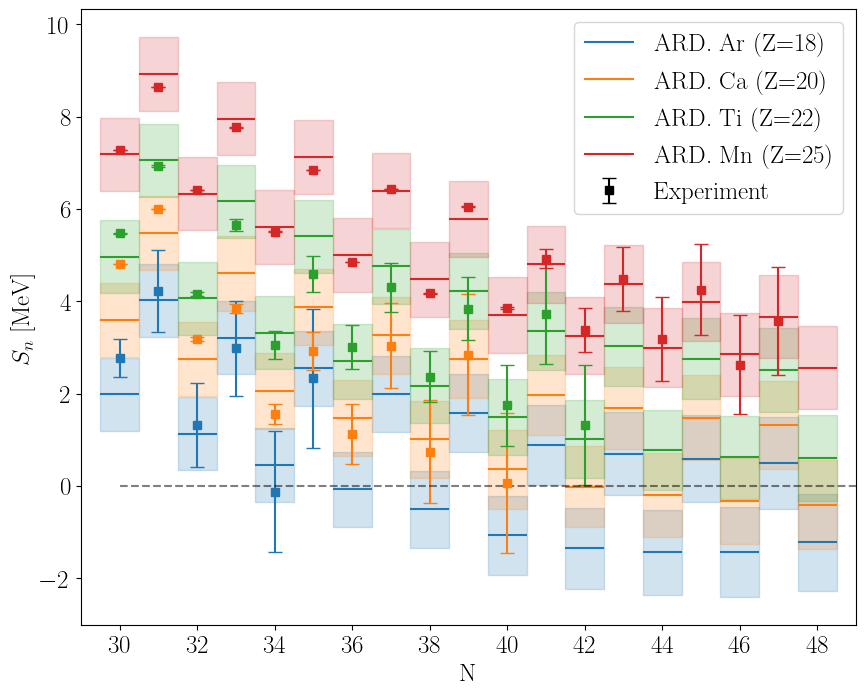

In [49]:
Zs = [ 18, 20, 22, 25]
names = ["Ar", "Ca", "Ti", "Mn"]
plot_several_separation_energies(Zs, 30, 49, names)

In [50]:
# do the same we had for the neutron separation energy but now for protons
def predict_sp(Z, N, model):
    model_up = model(Z+1, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_sp(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sp_exp"] = df[(df["Z"] == row["Z"]+1) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sp_exp"] = np.nan
    return df

def theory_sp(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+1) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [51]:
def get_experimiental_unc_sp(Z, N, df):
    try:
        return df[(df["Z"] == Z+1) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [52]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sp"] = sep_df.apply(lambda x: theory_sp(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [53]:
sep_df["exp_sp"] = experimental_sp(sep_df)["sp_exp"]
sep_df["unc_sp"] = uncertainty_sn(sep_df)["sp_exp"]

sep_df["sr_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], lambda Z, N: sr_be(Z, N, -1)[0]), axis=1)
sep_df["dz_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], dz_be), axis=1)


# model_pred_sp = make_pipeline(
#     PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
#     StandardScaler(),
#     ARDRegression(),
# )
# model_pred_sp.fit(sep_df.dropna().query("is_test == False")[["sr_sp", "dz_sp", "N", "Z"]].values,
#             sep_df.dropna().query("is_test == False")["exp_sp"])


def ensemble_sp(Z, N):
    up = simple_model_ensemble(Z+1, N)
    down = simple_model_ensemble(Z, N)
    return up[0] - down[0], (up[1]**2 + down[1]**2)**0.5


In [54]:
ensemble_sp(50, 50), predict_sp(50, 50, dz_be), predict_sp(50, 50, lambda Z, N: sr_be(Z, N, -1)[0])

((-3.738320689020952, 1.219373165509289),
 -3.6379699999999957,
 -2.0052905376636545)

In [55]:
sep_df["exp_sp"] = experimental_sp(sep_df)["sp_exp"]
sep_df["sr_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], lambda Z, N: sr_be(Z, N, -1)[0]), axis=1)
sep_df["dz_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], dz_be), axis=1)
ens_sp = sep_df.apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sp"] = [x[0] for x in ens_sp]
sep_df["unc_sp"] = [x[1] for x in ens_sp]


In [56]:
# compute the RMSE
dz_rmse = np.mean(np.abs((sep_df["exp_sp"] - sep_df["dz_sp"])))
sr_rmse = np.mean(np.abs((sep_df["exp_sp"] - sep_df["sr_sp"])))
ensm_rmse = np.mean(np.abs((sep_df["exp_sp"] - sep_df["ensemble_sp"])))
print(f"SR MAE: {sr_rmse}, DZ MAE: {dz_rmse}, Ensemble MAE: {ensm_rmse}")

SR MAE: 0.9576877142139448, DZ MAE: 0.8170302513089003, Ensemble MAE: 0.7717928522558537


In [57]:
def plot_sp_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models
    pres = [ensemble_sp(fixed_z, n) for n in range(n_min, n_max+1)]
    unc_pred = [p[1] for p in pres]
    pres = [p[0] for p in pres]
    predz = [predict_sp(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    predsr = [predict_sp(fixed_z, n, lambda Z, N: sr_be(Z, N, -1)[0]) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sp"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sp"]))

    sns.lineplot(x="N", y="exp_sp", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="ARDR", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="_")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo-Zucker", color="red", marker="*", s=200)
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=predsr, label=r"$Sp_{MISR}$", color="orange", marker="_", s=500)
    # sns.scatterplot(x="N", y="dz_sp", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="UNEDF1_sp", data=foo_df, label="UNDEF1", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max+1, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sp", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_p$ [MeV]")
    ax.set_xlim(n_min-1, n_max+1)
    ax.set_ylim(-4, 7)
    ax.legend(fontsize=22, loc="lower right", ncols=1)
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.2, 0.8), xycoords="axes fraction", fontsize=25)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


13 35


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_71907/2892716758.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="ARDR", color="blue", capsize=5, alpha=0.5)


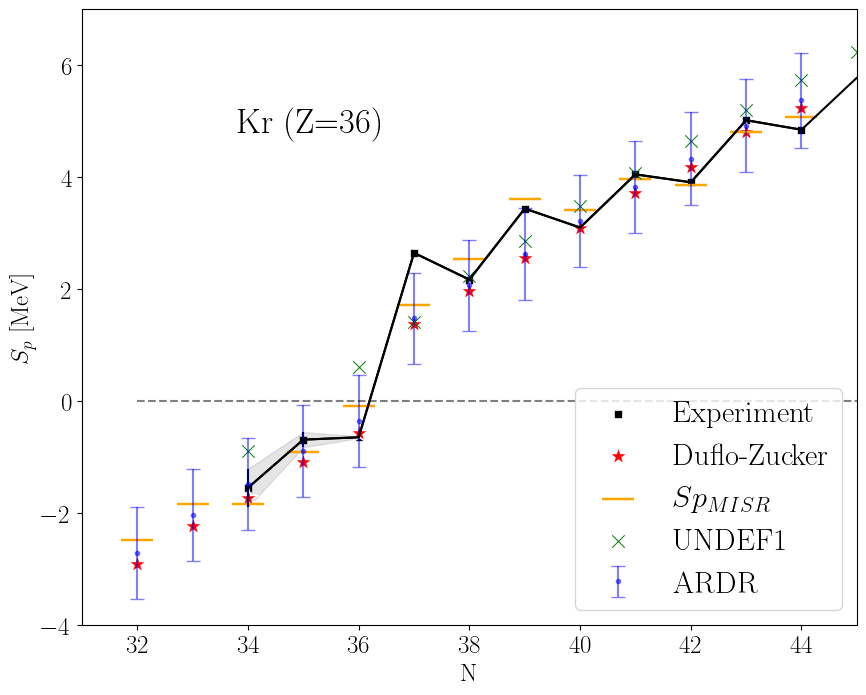

In [58]:
plot_sp_energy(36, 32, 44, "Kr (Z=36)", "./plots/sp_36.pdf")

# Two neutron separation energies

In [59]:
def predict_s2n(Z, N, model):
    model_up = model(Z, N+2)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_s2n(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2n_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+2)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2n_exp"] = np.nan
    return df

def theory_s2n(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+2)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2n(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+2)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan
sep_df["exp_s2n"] = experimental_s2n(sep_df)["s2n_exp"]
sep_df["sr_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], lambda Z, N: sr_be(Z, N, -1)[0]), axis=1)
sep_df["dz_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], dz_be), axis=1)
# model_s2n = make_pipeline(
#     PolynomialFeatures(degree=3, include_bias=True, interaction_only=False),
#     StandardScaler(),
#     ARDRegression(),
# )
# model_s2n.fit(sep_df.dropna().query("is_test == False")[["sr_s2n", "dz_s2n", "N", "Z"]].values,
#             sep_df.dropna().query("is_test == False")["exp_s2n"])

def ensemble_s2n(Z, N):
    # inpupt_sr = sr_be(Z, N+2)[0] - sr_be(Z, N)[0]
    # uncertainty_sr = (sr_be(Z, N+2)[1]**2 + sr_be(Z, N)[1]**2)**0.5
    # input_dz = dz_be(Z, N+2) - dz_be(Z, N)
    # pred, unc = model_s2n.predict(np.array([[inpupt_sr, input_dz, N, Z]]), return_std=True)
    # return pred[0], (unc[0]**2 + uncertainty_sr**2)**0.5
    up = simple_model_ensemble(Z, N+2)
    down = simple_model_ensemble(Z, N)
    return up[0] - down[0], (up[1]**2 + down[1]**2)**0.5

ens_s2n = sep_df.apply(lambda x: ensemble_s2n(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2n"] = [x[0] for x in ens_s2n]
sep_df["unc_s2n"] = [x[1] for x in ens_s2n]

# Two proton separation energies

In [60]:
def predict_s2p(Z, N, model):
    model_up = model(Z+2, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_s2p(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2p_exp"] = df[(df["Z"] == row["Z"]+2) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2p_exp"] = np.nan
    return df

def theory_s2p(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+2) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2p(Z, N, df):
    try:
        return df[(df["Z"] == Z+2) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

sep_df["exp_s2p"] = experimental_s2p(sep_df)["s2p_exp"]
sep_df["sr_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], lambda Z, N: sr_be(Z, N, -1)[0]), axis=1)
sep_df["dz_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], dz_be), axis=1)
# model_s2p = make_pipeline(
#     PolynomialFeatures(degree=3, include_bias=True, interaction_only=False),
#     StandardScaler(),
#     ARDRegression(),
# )
# model_s2p.fit(sep_df.dropna().query("is_test == False")[["sr_s2p", "dz_s2p", "N", "Z"]].values,
#             sep_df.dropna().query("is_test == False")["exp_s2p"])

def ensemble_s2p(Z, N):
    up = simple_model_ensemble(Z+2, N)
    down = simple_model_ensemble(Z, N)
    return up[0] - down[0], (up[1]**2 + down[1]**2)**0.5
    # inpupt_sr = sr_be(Z+2, N)[0] - sr_be(Z, N)[0]
    # uncertainty_sr = (sr_be(Z+2, N)[1]**2 + sr_be(Z, N)[1]**2)**0.5
    # input_dz = dz_be(Z+2, N) - dz_be(Z, N)
    # pred, unc = model_s2p.predict(np.array([[inpupt_sr, input_dz, N, Z]]), return_std=True)
    # return pred[0], (unc[0]**2 + uncertainty_sr**2)**0.5

ens_s2p = sep_df.apply(lambda x: ensemble_s2p(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2p"] = [x[0] for x in ens_s2p]
sep_df["unc_s2p"] = [x[1] for x in ens_s2p]



# Estimation of the probability of the separation energy being positive

In [61]:
import scipy.stats as stats
def probability_less_than_zero(mean, std_dev):
    probability = stats.norm.cdf(0, mean, std_dev)
    return probability


In [62]:
def estimate_proba_negative(Z, N, cal: callable):
    try:
        mean, std_dev = cal(Z, N)
    except:
        # raise ValueError("The model could not predict the value")
        return 1.
    return probability_less_than_zero(mean, std_dev)

In [63]:
def estimate_proba_bound(Z, N):
    # Estimate the probability of negative separation energies
    proba_negative_sn = estimate_proba_negative(Z, N, lambda Z, N: ensemble_sn(Z, N))
    proba_negative_sp = estimate_proba_negative(Z, N, lambda Z, N: ensemble_sp(Z, N))
    proba_negative_s2n = estimate_proba_negative(Z, N, lambda Z, N: ensemble_s2n(Z, N))
    proba_negative_s2p = estimate_proba_negative(Z, N, lambda Z, N: ensemble_s2p(Z, N))

    # Calculate the probability of positive separation energies
    proba_positive_sn = 1 - proba_negative_sn
    proba_positive_sp = 1 - proba_negative_sp
    proba_positive_s2n = 1 - proba_negative_s2n
    proba_positive_s2p = 1 - proba_negative_s2p

    # Calculate the total probability of the nucleus being bound
    # Assuming the separation energies are independent
    P_bound = proba_positive_sn * proba_positive_sp * proba_positive_s2n * proba_positive_s2p

    return P_bound


In [64]:
if True:
    Z_range = np.arange(13, 50)
    N_range = np.arange(10, 60)
    all_bound_matrix = np.full((len(Z_range), len(N_range)), 0.0)
    for i, Z in enumerate(tqdm(Z_range)):
        all_ns_in_z_exp = sep_df.query(f"Z == {Z}")["N"].values
        print(all_ns_in_z_exp)
        for j, N in enumerate(N_range):
            if N in list(range(all_ns_in_z_exp.min() - int(0.1 *Z), all_ns_in_z_exp.max() + int(0.7*Z))):
                try:
                    all_bound_matrix[i, j] = estimate_proba_bound(Z, N)
                except Exception as e:
                    all_bound_matrix[i, j] = 0.
            else:
                all_bound_matrix[i, j] = 0.

  0%|          | 0/37 [00:00<?, ?it/s]

[14 18 26 11 25 10 22 23 24  9 21 16 29 19 15 12 30 20 17 28 13 27]
[ 9 18 25 24 27 12 20 16 29 15 21 31 17 23 13 10 28 26 22 30 14 19 11]
[32 27 17 13 28 16 21 11 14 25 29 19 22 24 31 10 18 30 26  9 12 20 15 23]
[14 22 27 19 11 32 33 10 20 25 21 28 12 26 29 15 18 17 13 23 24 30 16 31]
[30 31 17 13 21 35 25 20 22 26 23 24 34 15 32 16 29 18 14 28 11 12 19 27
 33]
[25 16 14 18 36 33 17 30 32 21 34 35 27 20 29 31 13 15 26 12 19 24 28 22
 23 11]
[35 26 36 37 15 17 30 18 16 24 28 23 34 40 27 19 14 12 33 21 25 39 29 32
 20 13 31 22 38]
[26 25 35 23 32 20 39 16 15 28 41 21 30 38 27 34 40 13 19 29 17 36 18 24
 33 37 14 22 31]
[20 40 36 39 30 32 15 19 37 29 23 17 24 38 31 16 22 27 41 28 14 18 35 33
 26 21 25 42 34]
[35 28 27 22 34 38 37 31 26 16 20 17 24 19 21 29 18 41 36 23 42 40 25 39
 33 32 15 30 43]
[16 43 17 39 31 28 35 36 25 32 38 34 27 29 37 33 24 19 23 26 40 30 18 21
 44 42 20 41 22]
[44 25 28 27 33 18 23 24 22 38 17 40 31 39 34 43 37 20 42 19 32 21 45 41
 30 46 29 26 35 36]
[38 21 39 3

In [65]:
# all_bound_matrix = (1-proba_matrix_sn) * (1-proba_matrix_sp) * (1-proba_matrix_s2n) * (1-proba_matrix_s2p)

In [66]:
len(N_range),len(Z_range), all_bound_matrix.shape

(50, 37, (37, 50))

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nuclear_chart(proba_matrix = all_bound_matrix, title='Nuclear Stability Chart', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    # replace the isclose to 0 values with nan
    proba_matrix = np.where(proba_matrix < 1e-9, np.nan, proba_matrix)
    # ax.set_facecolor('white')
    cmap = plt.cm.get_cmap('RdYlBu_r').reversed()
    x, y = np.meshgrid(N_range, Z_range)
    chart = ax.pcolormesh(x, y, proba_matrix, cmap=cmap, alpha=0.9, linewidth=1.5, edgecolor='white')
    levels = [0.5]

    ## Put a vertical line on the predicted driplines
    for (iz, Z) in enumerate(Z_range):
        for (inn, N) in enumerate(N_range):
            # If the value of the probability goes from > 0.5 to < 0.5 or viceversa
            # Put a vertical line
            if proba_matrix[iz, inn] < 0.5 and proba_matrix[iz, inn-1] > 0.5:
                # The vertical line goes from y=Z-1 to y=Z and x= N
                ax.scatter(N-0.5, Z-0.5, color='lime', marker=2, s=200)
            elif proba_matrix[iz, inn] > 0.5 and proba_matrix[iz, inn-1] < 0.5:
                ax.scatter(N-0.5, Z-0.5, color='lime', marker=2, s=200)

    # Now repeat with horizontal lines
    for (inn, N) in enumerate(N_range):
        for (iz, Z) in enumerate(Z_range):
            # If the value of the probability goes from > 0.5 to < 0.5 or viceversa
            if proba_matrix[iz, inn] < 0.5 and proba_matrix[iz-1, inn] > 0.5:
                ax.scatter(N, Z-0.5, color='lime', marker="_", s=150)
            elif proba_matrix[iz, inn] > 0.5 and proba_matrix[iz-1, inn] < 0.5:
                ax.scatter(N, Z-0.5, color='lime', marker="_", s=150)

    all_sns_unbound = []
    all_sps_unbound = []
    all_s2ns_unbound = []
    all_s2ps_unbound = []

    sep_df.sort_values(by="N", inplace=True, ascending=True)
    for Z, N in zip(sep_df["Z"], sep_df["N"]):
            try:

                if sep_df[(sep_df.Z == Z) & (sep_df.N == N)]["exp_s2n"].values[0] < 0:
                    if estimate_proba_bound(Z, N) > 0.99:
                        continue
                    elif estimate_proba_bound(Z, N) != np.nan:
                        all_s2ns_unbound.append((N, Z))
                elif sep_df[(sep_df.Z == Z) & (sep_df.N == N)]["exp_s2p"].values[0] < 0:
                    if estimate_proba_bound(Z, N) > 0.99:
                        continue
                    elif estimate_proba_bound(Z, N) != np.nan:
                        all_s2ps_unbound.append((N, Z))
                elif sep_df[(sep_df.Z == Z) & (sep_df.N == N)]["exp_sp"].values[0] < 0:
                    if estimate_proba_bound(Z, N) > 0.99:
                        continue
                    elif estimate_proba_bound(Z, N) != np.nan:
                        all_sps_unbound.append((N, Z))
                elif sep_df[(sep_df.Z == Z) & (sep_df.N == N)]["exp_sn"].values[0] < 0:
                    if estimate_proba_bound(Z, N) > 0.99:
                        continue
                    elif estimate_proba_bound(Z, N) != np.nan:
                        all_sns_unbound.append((N, Z))
            except Exception as e:
                print(e, Z, N)

    sn = ax.scatter([x[0] for x in all_sns_unbound], [x[1] for x in all_sns_unbound], color='black', marker='P', s=40, label=r'Experimental $ S_n < 0$')
    sp = ax.scatter([x[0] for x in all_sps_unbound], [x[1] for x in all_sps_unbound], color='black', marker='s', s=40, label=r'Experimental $ S_p < 0$')
    s2n = ax.scatter([x[0] for x in all_s2ns_unbound], [x[1] for x in all_s2ns_unbound], color='black', marker='*', s=40, label=r'Experimental $ S_{2n} < 0$')
    s2p = ax.scatter([x[0] for x in all_s2ps_unbound], [x[1] for x in all_s2ps_unbound], color='black',  marker='o', s=40, label=r'Experimental $ S_{2p} < 0$')

    # Foo handle for the line
    p = ax.scatter([0], [0], color='lime', marker="_", s=150, label="$P_{bound}=0.5$")
    ax.legend(fontsize=20, loc='upper left', handles=[sn, sp, s2n, s2p, p])
    # ax.legend(fontsize=20, loc='upper left', handles=[sn, sp, s2n, s2p], title="Experiment")
    cbar = plt.colorbar(chart, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('$P_{bound}$', rotation=270, labelpad=18)
    ax.set_ylim(12, 50)
    ax.set_xlim(9, 60)
    ax.set_xlabel('N')
    ax.set_ylabel('Z')
    # make the background color light yellow
    ax.set_facecolor('mistyrose')
    plt.savefig("./plots/nuclear_limits.pdf", bbox_inches="tight")

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_71907/426545869.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r').reversed()


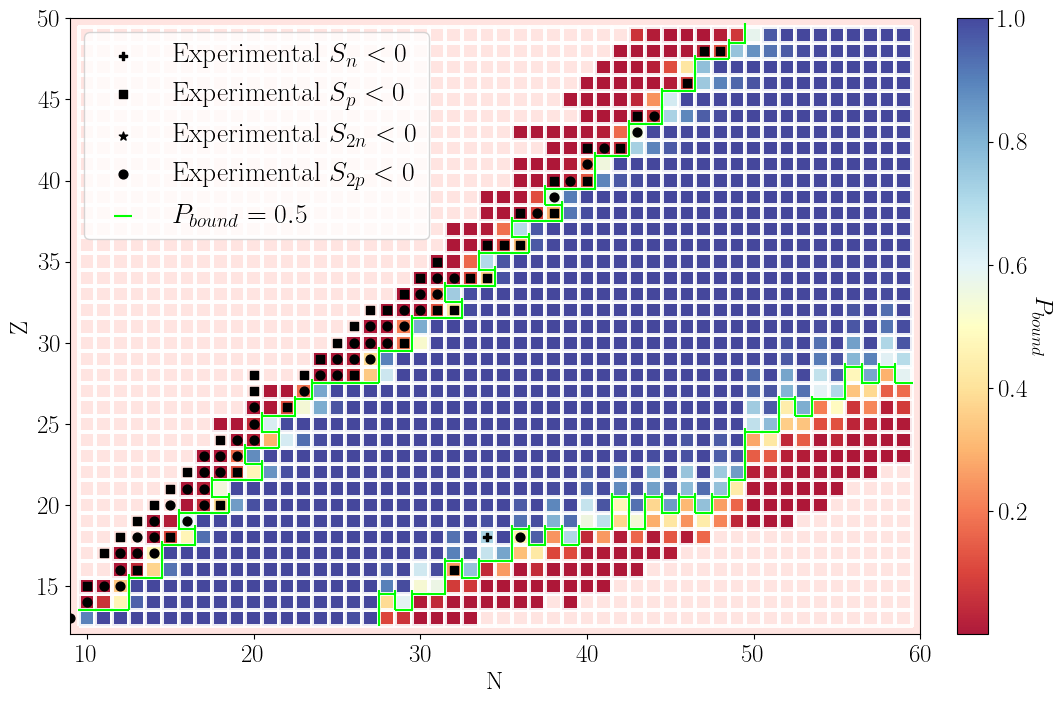

In [68]:
plot_nuclear_chart()

# Error analyisis

In [69]:
# Find where sn_exp is negative and the ensemble_sn is positive
errors_ensemble_sn = sep_df.query("exp_sn < 0 and ensemble_sn > 0 or exp_sn > 0 and ensemble_sn < 0")
errors_ensemble_sp = sep_df.query("exp_sp < 0 and ensemble_sp > 0 or exp_sp > 0 and ensemble_sp < 0")
errors_ensemble_s2n = sep_df.query("exp_s2n < 0 and ensemble_s2n > 0 or exp_s2n > 0 and ensemble_s2n < 0")
errors_ensemble_s2p = sep_df.query("exp_s2p < 0 and ensemble_s2p > 0 or exp_s2p > 0 and ensemble_s2p < 0")


In [70]:
print(f"Errors in the ensemble sn: {len(errors_ensemble_sn)}")
print(f"Errors in the ensemble sp: {len(errors_ensemble_sp)}")
print(f"Errors in the ensemble s2n: {len(errors_ensemble_s2n)}")
print(f"Errors in the ensemble s2p: {len(errors_ensemble_s2p)}")


Errors in the ensemble sn: 5
Errors in the ensemble sp: 19
Errors in the ensemble s2n: 2
Errors in the ensemble s2p: 19


In [71]:
# Now the same but for the Duflo-Zuker model
errors_dz_sn = sep_df.query("exp_sn < 0 and dz_sn > 0 or exp_sn > 0 and dz_sn < 0")
errors_dz_sp = sep_df.query("exp_sp < 0 and dz_sp > 0 or exp_sp > 0 and dz_sp < 0")
errors_dz_s2n = sep_df.query("exp_s2n < 0 and dz_s2n > 0 or exp_s2n > 0 and dz_s2n < 0")
errors_dz_s2p = sep_df.query("exp_s2p < 0 and dz_s2p > 0 or exp_s2p > 0 and dz_s2p < 0")



In [72]:
print(f"Errors in the Duflo-Zuker sn: {len(errors_dz_sn)}")
print(f"Errors in the Duflo-Zuker sp: {len(errors_dz_sp)}")
print(f"Errors in the Duflo-Zuker s2n: {len(errors_dz_s2n)}")
print(f"Errors in the Duflo-Zuker s2p: {len(errors_dz_s2p)}")


Errors in the Duflo-Zuker sn: 5
Errors in the Duflo-Zuker sp: 23
Errors in the Duflo-Zuker s2n: 1
Errors in the Duflo-Zuker s2p: 20


In [73]:
# Now the same but for the SR model
errors_sr_sn = sep_df.query("exp_sn < 0 and sr_sn > 0 or exp_sn > 0 and sr_sn < 0")
errors_sr_sp = sep_df.query("exp_sp < 0 and sr_sp > 0 or exp_sp > 0 and sr_sp < 0")
errors_sr_s2n = sep_df.query("exp_s2n < 0 and sr_s2n > 0 or exp_s2n > 0 and sr_s2n < 0")
errors_sr_s2p = sep_df.query("exp_s2p < 0 and sr_s2p > 0 or exp_s2p > 0 and sr_s2p < 0")


In [74]:
print(f"Errors in the SR sn: {len(errors_sr_sn)}")
print(f"Errors in the SR sp: {len(errors_sr_sp)}")
print(f"Errors in the SR s2n: {len(errors_sr_s2n)}")
print(f"Errors in the SR s2p: {len(errors_sr_s2p)}")

Errors in the SR sn: 7
Errors in the SR sp: 26
Errors in the SR s2n: 2
Errors in the SR s2p: 29


In [75]:
# For the sp, find the errors in the dz not in the ensemble
zn_errors_dz_sp = errors_dz_sp[["Z", "N"]].values
zn_errors_ens_sp = errors_ensemble_sp[["Z", "N"]].values
fixed_sps = [e for e in zn_errors_dz_sp if e not in zn_errors_ens_sp]
fixed_sps

[]